In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
trained_model_dir = "results/"

template = "cifar10/ResNet18OAT-2BN/{}_e30-b100_sgd-lr0.1-m0.9-wd0.0005_cos_disc-ew-[0.0, 0.1, 0.2, 0.3, 0.4, 1.0]-rand-d128/eval/{}.txt"

def get_robust_accuracy(test_adversarial):
    train_adversarial = "original"
    path = trained_model_dir + template.format("original", test_adversarial)
    file = open(path)
    acc = file.readlines()[-2]
    file.close()
    robust_acc = float(acc.split()[-1])
    
    return robust_acc

def get_trained_robust_accuracy(test_adversarial):
    path = trained_model_dir + template.format(test_adversarial, test_adversarial)
    file = open(path)
    acc = file.readlines()[-2]
    file.close()
    trained_robust_acc = float(acc.split()[-1])
    
    return trained_robust_acc

def get_cross_robust_accuracy(train_adversarial, test_adversarial):
    path = trained_model_dir + template.format(train_adversarial, test_adversarial)
    file = open(path)
    acc = file.readlines()[-2]
    file.close()
    cross_robust_acc = float(acc.split()[-1])
    
    return cross_robust_acc

In [41]:
train = "autoattack"
test = "pgd"

trained_robust_accuracy = get_trained_robust_accuracy(test)
cross_robust_accuracy = get_cross_robust_accuracy(train, test)

print("Train Data: ", train)
print("Test Data: ", test)
print("=================")
print("RobustAccuracy({},{}): {}".format(test, test, trained_robust_accuracy))
print("RobustAccuracy({},{}): {} ".format(train, test, cross_robust_accuracy))

Train Data:  autoattack
Test Data:  pgd
RobustAccuracy(pgd,pgd): 0.7532
RobustAccuracy(autoattack,pgd): 0.788 


In [44]:
train = "pgd"
test = "autoattack"

trained_robust_accuracy = get_trained_robust_accuracy(test)
cross_robust_accuracy = get_cross_robust_accuracy(train, test)

print("Train Data: ", train)
print("Test Data: ", test)
print("=================")
print("RobustAccuracy({},{}): {}".format(test, test, trained_robust_accuracy))
print("RobustAccuracy({},{}): {} ".format(train, test, cross_robust_accuracy))

Train Data:  pgd
Test Data:  autoattack
RobustAccuracy(autoattack,autoattack): 0.816
RobustAccuracy(pgd,autoattack): 0.7758 


In [6]:
def robust_accuracies(attacks) :
    accs = []
    names = []
    for a in attacks :
        accs.append(get_robust_accuracy(a))
        names.append(a)
    return accs, names

def trained_robust_accuracies(attacks) :
    accs = []
    names = []
    for a in attacks :
        accs.append(get_trained_robust_accuracy(a))
        names.append(a)
    return accs, names    

In [8]:
TOOLBOX_ADV_ATTACK_LIST = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "squareattack", "deepfool", "newtonfool", "pixelattack", "spatialtransformation"]

attacks = TOOLBOX_ADV_ATTACK_LIST

In [9]:
robust_accs, names = robust_accuracies(attacks)
trained_robust_accs, names = trained_robust_accuracies(attacks)

In [10]:
robust_accs

[0.4211,
 0.4238,
 0.4498,
 0.7678,
 0.5501,
 0.4205,
 0.8316,
 0.6999,
 0.745,
 0.1037,
 0.5569]

In [11]:
trained_robust_accs

[0.816,
 0.7739,
 0.8115,
 0.8879,
 0.7246,
 0.7532,
 0.9011,
 0.8814,
 0.884,
 0.8857,
 0.8427]

In [12]:
names

['autoattack',
 'autopgd',
 'bim',
 'cw',
 'fgsm',
 'pgd',
 'squareattack',
 'deepfool',
 'newtonfool',
 'pixelattack',
 'spatialtransformation']

In [13]:
df = pd.DataFrame(data={"attack": names, "robust_accuracy": robust_accs, "trained_robust_accuracy": trained_robust_accs})

In [14]:
df["improvement"] = df["trained_robust_accuracy"] - df["robust_accuracy"]

In [15]:
df

,attack,robust_accuracy,trained_robust_accuracy,improvement
0,autoattack,0.4211,0.8160,0.3949
1,autopgd,0.4238,0.7739,0.3501
2,bim,0.4498,0.8115,0.3617
3,cw,0.7678,0.8879,0.1201
4,fgsm,0.5501,0.7246,0.1745
5,pgd,0.4205,0.7532,0.3327
6,squareattack,0.8316,0.9011,0.0695
7,deepfool,0.6999,0.8814,0.1815
8,newtonfool,0.7450,0.8840,0.1390
9,pixelattack,0.1037,0.8857,0.7820


$A(M, X_B)$ = robust_accuracy

$A(M_B, X_B)$ = trained_robust_accuracy

$A(M_B, X_C)$ = cross_robust_accuracy

## RQ1 - Motivating work

We hypothesize that each adversarial attack has a unique characteristic, thus the test cases generated from each adversarial attack are not targeting the same bug. To prove if the accuracy is not enough in measuring the performance of adversarial attacks, we need to demonstrate that $bugs_{X_C} \nsubseteq bugs_{X_B}$ and $bugs_{X_B} \nsubseteq bugs_{X_C}$. In the other word, there exist at least 2 adversarial examples $X_B$ and $X_C$ such that $A(M_C, X_B) < A(M_B, X_B)$ and $A(M_B, X_C) < A(M_C, X_C)$.

In [16]:
def compare(a1, a2):
    trained_robust_acc = get_trained_robust_accuracy(a1) 
    cross_robust_acc = get_cross_robust_accuracy(a2, a1)
#     print("Trained Robust Accuracy: ", trained_robust_acc)
#     print("Cross Robust Accuracy: ", cross_robust_acc)
    return trained_robust_acc - cross_robust_acc

In [17]:
def get_comparison_metrics(attacks) :
    metrics = {}
    for a1 in attacks :
        m = {}
        for a2 in attacks :
            m[a2] = compare(a1, a2)
        metrics[a1] = m  
    return metrics
    
def plot_heatmap(metrics, cmap, fpath, vmin, vmax, annot=True): 

    df = pd.DataFrame(data=metrics)

    plt.figure(figsize=(12,9))
    fig = sns.heatmap(df, cmap=cmap, vmin=vmin, vmax=vmax, annot=annot, fmt=".3f", linewidth=0.7)
#     fig.set(xlabel='Train', ylabel='Test')
    fig.figure.savefig(fpath, bbox_inches='tight')
    plt.show()

In [18]:
metrics = get_comparison_metrics(attacks)

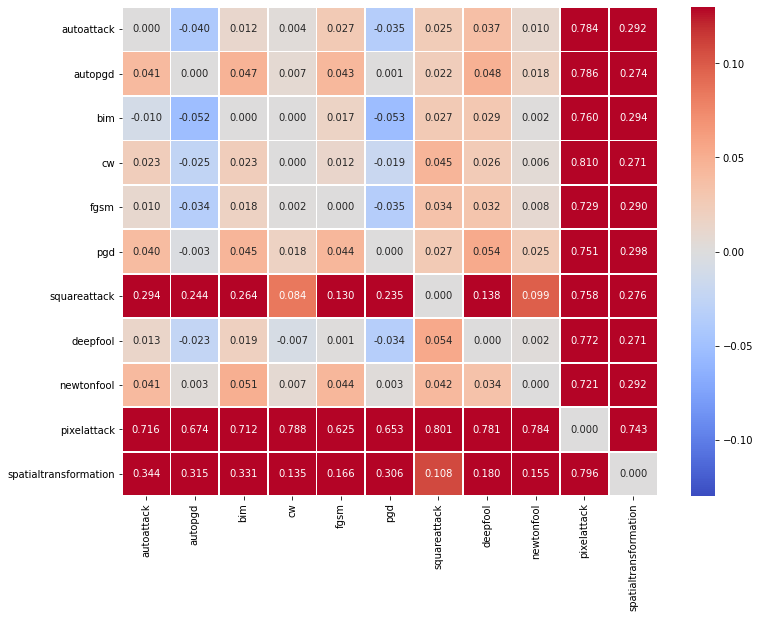

In [19]:
plot_heatmap(metrics, "coolwarm", "plot/rq1.png", vmin=-0.13, vmax=0.13, annot=True)

$A(M_B, X_C) < A(M_C, X_C)$ is satisfied when $A(M_C, X_C) - A(M_B, X_C) > 0$. In the heatmap above, the value represent the difference between $A(M_C, X_C)$ and $A(M_B, X_C)$. We can see that several heatmaps have the red-like color which prove that this happen.

For an example, if we take SpatialTransformation and PixelAttack then we get

    
* $A(M'_{SpatialTransformation}, X'_{PixelAttack}) - A(M'_{PixelAttack}, X'_{PixelAttack})$ = 0.65
* $A(M'_{PixelAttack}, X'_{SpatialTranformation}) - A(M'_{SpatialTranformation}, X'_{SpatialTranformation})$ = 0.53


It proves that SpatialTransformation has test cases that are attacking different bugs from any test cases in PixelAttack and vice versa. From this heatmap, we get 26 pairs of adversarial attacks that satisfy $A(M'_2, X'_2) - A(M'_1, X'_2) > 0$ and $A(M'_1, X'_1) - A(M'_2, X'_1) > 0$. 

In [25]:
# Make Sure
train = "spatialtransformation"
test = "pixelattack"

trained_robust_accuracy = get_trained_robust_accuracy(train)
cross_robust_accuracy = get_cross_robust_accuracy(test, train)

print("Train Data: ", train)
print("Test Data: ", test)
print("=================")
print("Trained Robust Accuracy: ", trained_robust_accuracy)
print("Cross Robust Accuracy: ", cross_robust_accuracy)

Train Data:  spatialtransformation
Test Data:  pixelattack
Trained Robust Accuracy:  0.8427
Cross Robust Accuracy:  0.1


$A(M'_{SpatialTransformation}, X'_{PixelAttack}) - A(M'_{PixelAttack}, X'_{PixelAttack})$ = 0.7551 - 0.1 = 0.65

In [26]:
indexs =[]
attack_types = []
attack_the_same_bugs = "Attack The Same Bug"
attack_the_different_bugs = "Attack The DIfferent Bug"
proof = set()
for a1 in attacks : 
    for a2 in attacks :
        if a1 != a2 :
            index = None
            if a1 > a2 :
                index = a1 + "-" + a2
            else :
                index = a2 + "-" + a1

            indexs.append(index)
            if metrics[a1][a2] > 0 and metrics[a2][a1] > 0 :
                proof.add(index)
                attack_types.append(attack_the_different_bugs)
            else :
                attack_types.append(attack_the_same_bugs)
            
# len(proof)
# proof

In [27]:
df_attack_types = pd.DataFrame(data={"index": indexs, "attack_types": attack_types})

df_attack_types = df_attack_types.drop_duplicates().reset_index(drop=True)
df_attack_types.head()

,index,attack_types
0,autopgd-autoattack,Attack The Same Bug
1,bim-autoattack,Attack The Same Bug
2,cw-autoattack,Attack The DIfferent Bug
3,fgsm-autoattack,Attack The DIfferent Bug
4,pgd-autoattack,Attack The Same Bug


In [28]:
df_attack_types.groupby("attack_types").count()

,index
attack_types,
Attack The DIfferent Bug,42
Attack The Same Bug,13


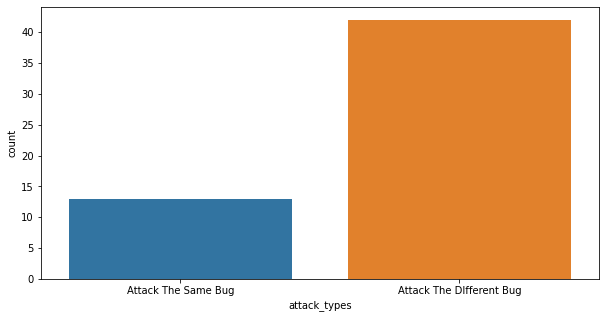

In [29]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df_attack_types, x="attack_types")
fpath = "plot/rq1-histogram.png"
fig.figure.savefig(fpath)
plt.show()

In [30]:
different_bugs_metrics = {}


for a1 in attacks : 
    sm = {}
    for a2 in attacks :
        id = a1 + "-" + a2 
        if a1 + "-" + a2  in proof or a2 + "-" + a1 in proof :
            sm[a2] = 1
        else :
            sm[a2] = 0
    different_bugs_metrics[a1] = sm
    
different_bugs_metrics = pd.DataFrame(data=different_bugs_metrics)

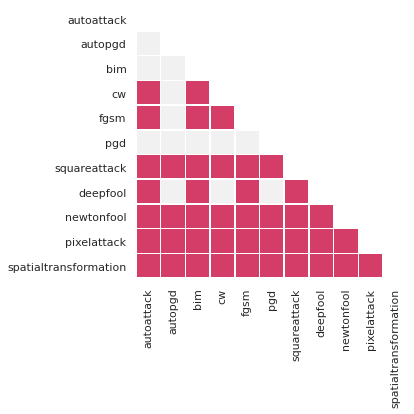

In [31]:
def plot_half_heatmap(data, cmap, path) :
    sns.set_theme(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(different_bugs_metrics, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 5))

    # Draw the heatmap with the mask and correct aspect ratio
    f = sns.heatmap(data, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar=False)
    f.figure.savefig(path, bbox_inches='tight')

def plot_heatmap(data, cmap, path, annot=False) :
    sns.set_theme(style="white")

    # Draw the heatmap with the mask and correct aspect ratio
    if annot :
        f, ax = plt.subplots(figsize=(12, 6))
        f = sns.heatmap(data, cmap=cmap, vmax=1, center=0, annot=annot, fmt=".3f",
                        linewidths=.5, cbar_kws={"shrink": .5})
        f.figure.savefig(path, bbox_inches='tight')
    else :
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(8, 5))
        f = sns.heatmap(data, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar=False)
        f.figure.savefig(path, bbox_inches='tight')


# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0,s=75, l=50, n=1, as_cmap=True)

path = "plot/rq1-attack-diffferent-bugs.png"

plot_half_heatmap(different_bugs_metrics, cmap, path)

In the contrary, the AutoAttack, AutoPGD, BIM, CW , FGSM, and PGD, both have a 0 value. The test cases generated from those adversarial attacks don't attack the different bugs. we know that $bugs_{X_B} \subset bugs_{X_C}$ is satisfied if $A(M_C, X_B) > A(M_B, X_B)$ and $A(M_B, X_C) < A(M_C, X_C)$.

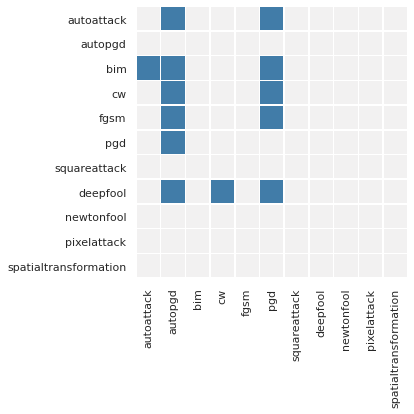

In [32]:
subset_bugs_metrics = {}

for a1 in attacks : 
    sm = {}
    for a2 in attacks :
        id = a1 + "-" + a2 
        if metrics[a1][a2] < 0 and metrics[a2][a1] > 0 :
            sm[a2] = -1
        else :
            sm[a2] = 0
    subset_bugs_metrics[a1] = sm

subset_bugs_metrics = pd.DataFrame(data=subset_bugs_metrics)
    
# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=240, h_pos=0,s=75, l=50, n=1, as_cmap=True)

path = "plot/rq1-subset-bugs.png"

plot_heatmap(subset_bugs_metrics, cmap, path)

In the Figure above, the horisontal axis means the first term used and the vertical axis is the second term used. For example, from the above metric, $bugs_{X_{AutoPGD}} \subset bugs_{X_{AutoAttack}}$, $bugs_{X_{FGSM}} \subset bugs_{X_{PGD}}$, $bugs_{X_{DeepFool}} \subset bugs_{X_{NewtonFool}}$, etc.

## RQ2 - How to use BSEM? How BSEM compared to the existing metric?

Given a model $M$, an original data $X$, a list of $n$ adversarial attack $AA = \{ aa_1, aa_2, aa_3, ... , aa_n \}$, an adversarial defense technique $AD$. First, we generate adversarial examples using each adversarial attack from $AA$. For each pair of adversarial examples generated from different adversarial attack, we measure BSEM. Then we make a leaderboard that mimic the existing evaluation relative to the adversarial defense $AD$.

### One Way Relation

In [33]:
def one_pov_relation(a1, a2):
    robust_acc = get_robust_accuracy(a2)
    trained_robust_acc = get_trained_robust_accuracy(a2)
    cross_robust_acc = get_cross_robust_accuracy(a1, a2)
#     print("RobustAccuracy(original, {}): {:.4f}".format(a2, robust_acc))
#     print("RobustAccuracy({}, {}): {:.4f}".format(a2, a2, trained_robust_acc))
#     print("RobustAccuracy({}, {}): {:.4f}".format(a1, a2, cross_robust_acc))
    return (min(cross_robust_acc, trained_robust_acc) - robust_acc) / (trained_robust_acc - robust_acc)


def measure_relation(a1, a2) :
#     print((one_pov_relation(a1, a2) + one_pov_relation(a2, a1))/2)
#     return max(0, (one_pov_relation(a1, a2) + one_pov_relation(a2, a1))/2)
    return max(0, one_pov_relation(a1, a2))


In [34]:
# measure_relation("spatialtransformation", "ffgsm")
measure_relation("pgd", "autoattack")

0.8982020764750572

In [35]:
measure_relation("squareattack", "autoattack")

0.2547480374778427

In [36]:
measure_relation("autoattack", "squareattack")

0.6359712230215829

In [37]:
#TODO: 
# cek formula -> what does it means?
# benerin angka dibelakakgn koma

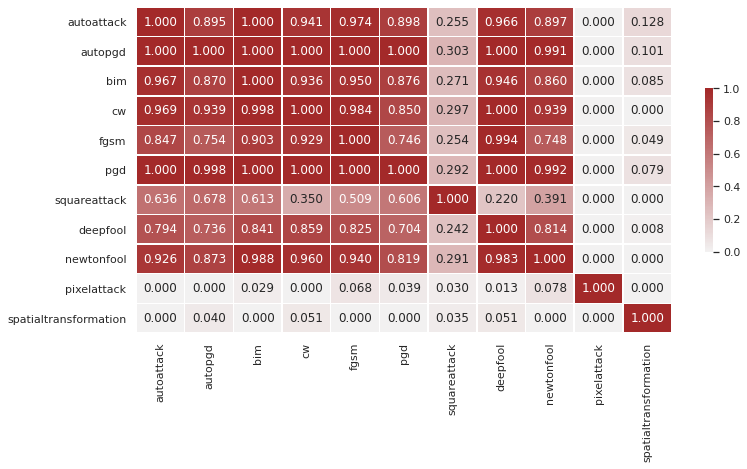

In [38]:
# owr: one way relation
owr = {}
for a1 in attacks :
    m = {}
    for a2 in attacks :
        m[a2] = measure_relation(a1, a2)
    owr[a1] = m

owr = pd.DataFrame(data=owr)


# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=300, h_pos=12.2,s=75, l=37, n=1, as_cmap=True)

path = "plot/rq2-bsem.png"

plot_heatmap(owr, cmap, path, annot=True)

In [39]:
leaderboard = df[["attack","robust_accuracy"]]
leaderboard.sort_values(["robust_accuracy"]).reset_index(drop=True)

,attack,robust_accuracy
0,pixelattack,0.1037
1,pgd,0.4205
2,autoattack,0.4211
3,autopgd,0.4238
4,bim,0.4498
5,fgsm,0.5501
6,spatialtransformation,0.5569
7,deepfool,0.6999
8,newtonfool,0.7450
9,cw,0.7678


From the leaderboard, AutoAttack is the best one. But it seems that PixelAttack and SpatialTransformation are attacking the different bugs compared to another attacks. None of attacks are looks similar with PixelAttack nor Spatial Transformatrion.